In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import sys
from glob import glob


from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
#import mplfinance as mpf
import seaborn as sns
import yfinance as yf


# Add the src directory to the path
src_dir = os.getenv('SRC_DIR')
if src_dir is None:
	# Fallback: assume notebooks folder is one level below project root
	project_root = os.path.dirname(os.getcwd())
	src_dir = os.path.join(project_root, 'src')
print(f"Adding to path: {src_dir}")
sys.path.append(src_dir)

from utils.logger import get_logger
_logs = get_logger(__name__)

Adding to path: ../src/


In [ ]:
#Random Forest Classifer with sentiment - 59 features

In [ ]:
# Load data
# Define ordered column names to enforce consistent schema (overrides original file header)
columns = [
    'Date', 
    'Close',          
    'Open', 
    'High',                
    'Low', 
    'Volume'
]
btc_ocs_columns=["Date","Close","Open","High","Low","Volume","Sentiment"]

btc_file = os.getenv("BTC_DATA")
# Btc data with sentiment to be used for this model
btc_ocs_file= os.getenv("COMBINED_DATA")

# Read the raw CSV:
btc_dt= (pd.read_csv(btc_ocs_file,  usecols= btc_ocs_columns ))



In [113]:
#setting Date as the date time type index
btc_dt["Date"]=pd.to_datetime(btc_dt["Date"])
btc_dt.set_index("Date",drop=True,inplace=True)

In [114]:
from datetime import date
from math import sin, cos, pi
import numpy as np
#Extracting features from date
btc_dt['Year'] = btc_dt.index.year
btc_dt['Month'] = btc_dt.index.month
btc_dt['Day'] = btc_dt.index.day
btc_dt['Dow']=btc_dt.index.dayofweek

#Giving momnth and day cylical attributes
btc_dt['month_sin'] =  np.sin(2 * pi * (btc_dt['Month'] - 1) / 12)
btc_dt['month_cos'] = np.cos(2 * pi * (btc_dt['Month'] - 1) / 12)
btc_dt['dow_sin'] = np.sin(2 * pi * btc_dt['Dow'] / 7)
btc_dt['dow_cos'] = np.cos(2 * pi * btc_dt['Dow'] / 7)

In [115]:
# Signal whether to buy or not 
btc_dt['Open-Close']  = btc_dt['Open'] - btc_dt['Close']
btc_dt['Low-High']  = btc_dt['Low'] - btc_dt['High']

# Add Lagging indicatora for open,close,high,low and volume
lag_features=["Close","Open","High","Low"]
for lag_feature in lag_features:
    for i in range(1,6,1):
        lag_feature_name=f"lag_{lag_feature}_{i}"
        btc_dt[lag_feature_name]=btc_dt[lag_feature].shift(i)

# Create target column with 1% price sensitivity
btc_dt['Target'] = np.where(btc_dt['Close'].shift(-1) > btc_dt['Close'] * 1.01, 1, 0)



In [116]:
btc_dt

,Close,Open,High,Low,Volume,Sentiment,Year,Month,Day,Dow,...,lag_High_2,lag_High_3,lag_High_4,lag_High_5,lag_Low_1,lag_Low_2,lag_Low_3,lag_Low_4,lag_Low_5,Target
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-05,15608.21,14165.86,15775.00,14115.00,40856321439,1,2020,11,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-11-06,15599.95,15608.06,15977.67,15190.36,39837841971,1,2020,11,6,4,...,NaN,NaN,NaN,NaN,14115.00,NaN,NaN,NaN,NaN,0
2020-11-07,14834.09,15599.95,15779.24,14310.00,35024953706,1,2020,11,7,5,...,15775.00,NaN,NaN,NaN,15190.36,14115.00,NaN,NaN,NaN,1
2020-11-08,15482.90,14834.09,15666.00,14721.90,26632075029,1,2020,11,8,6,...,15977.67,15775.00,NaN,NaN,14310.00,15190.36,14115.00,NaN,NaN,0
2020-11-09,15342.25,15482.89,15856.90,14817.14,34149115566,0,2020,11,9,0,...,15779.24,15977.67,15775.00,NaN,14721.90,14310.00,15190.36,14115.00,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-01,110052.25,109555.63,110500.00,109342.47,34284209459,1,2025,11,1,5,...,111629.20,113690.17,116114.13,116410.06,108266.11,106279.33,109000.00,112203.00,113833.12,0
2025-11-02,110536.01,110052.25,111221.99,108800.00,34284209459,1,2025,11,2,6,...,111066.10,111629.20,113690.17,116114.13,109342.47,108266.11,106279.33,109000.00,112203.00,0
2025-11-03,106557.98,110533.83,110749.00,105271.67,74247200768,0,2025,11,3,0,...,110500.00,111066.10,111629.20,113690.17,108800.00,109342.47,108266.11,106279.33,109000.00,0


In [117]:
# Technical Analysis Features

# Moving Averages
btc_dt['MA_7'] = btc_dt['Close'].rolling(window=7).mean()
btc_dt['MA_14'] = btc_dt['Close'].rolling(window=14).mean()
btc_dt['MA_21'] = btc_dt['Close'].rolling(window=21).mean()
btc_dt['MA_50'] = btc_dt['Close'].rolling(window=30).mean()
#btc_dt['MA_200'] = btc_dt['Close'].rolling(window=200).mean()

# Exponential Moving Averages
btc_dt['EMA_12'] = btc_dt['Close'].ewm(span=12, adjust=False).mean()
btc_dt['EMA_26'] = btc_dt['Close'].ewm(span=26, adjust=False).mean()

# MACD (Moving Average Convergence Divergence)
btc_dt['MACD'] = btc_dt['EMA_12'] - btc_dt['EMA_26']
btc_dt['MACD_Signal'] = btc_dt['MACD'].ewm(span=9, adjust=False).mean()
btc_dt['MACD_Histogram'] = btc_dt['MACD'] - btc_dt['MACD_Signal']

# Relative Strength Index (RSI)
delta = btc_dt['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
btc_dt['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
btc_dt['BB_Middle'] = btc_dt['Close'].rolling(window=20).mean()
bb_std = btc_dt['Close'].rolling(window=20).std()
btc_dt['BB_Upper'] = btc_dt['BB_Middle'] + (bb_std * 2)
btc_dt['BB_Lower'] = btc_dt['BB_Middle'] - (bb_std * 2)
btc_dt['BB_Width'] = btc_dt['BB_Upper'] - btc_dt['BB_Lower']

# Price Rate of Change (ROC)
btc_dt['ROC'] = ((btc_dt['Close'] - btc_dt['Close'].shift(10)) / btc_dt['Close'].shift(10)) * 100

# Average True Range (ATR) - Volatility Indicator
high_low = btc_dt['High'] - btc_dt['Low']
high_close = np.abs(btc_dt['High'] - btc_dt['Close'].shift())
low_close = np.abs(btc_dt['Low'] - btc_dt['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
btc_dt['ATR'] = true_range.rolling(window=14).mean()

# Stochastic Oscillator
low_14 = btc_dt['Low'].rolling(window=14).min()
high_14 = btc_dt['High'].rolling(window=14).max()
btc_dt['Stochastic_%K'] = 100 * ((btc_dt['Close'] - low_14) / (high_14 - low_14))
btc_dt['Stochastic_%D'] = btc_dt['Stochastic_%K'].rolling(window=3).mean()

# On-Balance Volume (OBV)
btc_dt['OBV'] = (np.sign(btc_dt['Close'].diff()) * btc_dt['Volume']).fillna(0).cumsum()

# Volume Rate of Change
btc_dt['Volume_ROC'] = ((btc_dt['Volume'] - btc_dt['Volume'].shift(5)) / btc_dt['Volume'].shift(5)) * 100

# Price momentum
btc_dt['Momentum'] = btc_dt['Close'] - btc_dt['Close'].shift(4)

# Percentage change features
btc_dt['Daily_Return'] = btc_dt['Close'].pct_change() * 100
btc_dt['Volatility_10'] = btc_dt['Daily_Return'].rolling(window=10).std()
btc_dt['Volatility_30'] = btc_dt['Daily_Return'].rolling(window=30).std()

In [ ]:
# Shift Target one data row
btc_dt["Target"]=btc_dt["Target"].shift(-1)

In [119]:
btc_dt

,Close,Open,High,Low,Volume,Sentiment,Year,Month,Day,Dow,...,ROC,ATR,Stochastic_%K,Stochastic_%D,OBV,Volume_ROC,Momentum,Daily_Return,Volatility_10,Volatility_30
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-05,15608.21,14165.86,15775.00,14115.00,40856321439,1,2020,11,5,3,...,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN
2020-11-06,15599.95,15608.06,15977.67,15190.36,39837841971,1,2020,11,6,4,...,NaN,NaN,NaN,NaN,-3.983784e+10,NaN,NaN,-0.052921,NaN,NaN
2020-11-07,14834.09,15599.95,15779.24,14310.00,35024953706,1,2020,11,7,5,...,NaN,NaN,NaN,NaN,-7.486280e+10,NaN,NaN,-4.909375,NaN,NaN
2020-11-08,15482.90,14834.09,15666.00,14721.90,26632075029,1,2020,11,8,6,...,NaN,NaN,NaN,NaN,-4.823072e+10,NaN,NaN,4.373777,NaN,NaN
2020-11-09,15342.25,15482.89,15856.90,14817.14,34149115566,0,2020,11,9,0,...,NaN,NaN,NaN,NaN,-8.237984e+10,NaN,-265.96,-0.908422,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-01,110052.25,109555.63,110500.00,109342.47,34284209459,1,2025,11,1,5,...,2.292371,3514.302143,38.386209,36.372769,2.668850e+11,-46.869306,-2854.50,0.453634,1.644630,2.147360
2025-11-02,110536.01,110052.25,111221.99,108800.00,34284209459,1,2025,11,2,6,...,0.381398,3443.890714,42.017505,37.991224,3.011692e+11,-46.869306,503.88,0.439573,1.474029,2.128293
2025-11-03,106557.98,110533.83,110749.00,105271.67,74247200768,0,2025,11,3,0,...,-4.038242,3528.079286,11.548437,30.650717,2.269220e+11,6.563766,-1750.20,-3.598854,1.833426,2.208918


In [ ]:
# Find Data Rrows with null values and filter the rows
btc_dt_trim_1=btc_dt[30:len(btc_dt)-1]
columns_with_null=btc_dt_trim_1.isnull().sum()
sum(columns_with_null>0)




0

In [121]:
#Pick features for first run , Only picking  features with out null values
all_columns=btc_dt_trim_1.columns
features_1=all_columns[btc_dt_trim_1.isnull().sum()==0]
lstm1_df=btc_dt_trim_1[features_1]
print(features_1,len(features_1))

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Sentiment', 'Year', 'Month',
       'Day', 'Dow', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos',
       'Open-Close', 'Low-High', 'lag_Close_1', 'lag_Close_2', 'lag_Close_3',
       'lag_Close_4', 'lag_Close_5', 'lag_Open_1', 'lag_Open_2', 'lag_Open_3',
       'lag_Open_4', 'lag_Open_5', 'lag_High_1', 'lag_High_2', 'lag_High_3',
       'lag_High_4', 'lag_High_5', 'lag_Low_1', 'lag_Low_2', 'lag_Low_3',
       'lag_Low_4', 'lag_Low_5', 'Target', 'MA_7', 'MA_14', 'MA_21', 'MA_50',
       'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI',
       'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'ROC', 'ATR',
       'Stochastic_%K', 'Stochastic_%D', 'OBV', 'Volume_ROC', 'Momentum',
       'Daily_Return', 'Volatility_10', 'Volatility_30'],
      dtype='object') 61


In [122]:
#We have a data set lstm1_df. Apply Min max scaler on all columns except sin and cos month and day of week.
from sklearn.preprocessing import StandardScaler
lstm1_features= [col for col in lstm1_df.columns if col not in ["Month","Dow"] ]
lstm1_df=lstm1_df[lstm1_features]

#
lstm1_X=lstm1_df[lstm1_df.columns[lstm1_df.columns!="Target"]]
lstm1_y=lstm1_df["Target"]

#Apply the sclaers
stan_scaler=StandardScaler()
lstm1_X_features_to_scaler=[col for col in lstm1_X.columns if col not in ["month_sin","month_cos","dow_sin","dow_cos"]]
lstm1_X_scaled=lstm1_X
lstm1_X_scaled[lstm1_X_features_to_scaler]=stan_scaler.fit_transform(lstm1_X_scaled[lstm1_X_features_to_scaler])

C:\Users\kirti\AppData\Local\Temp\ipykernel_10328\2985941197.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm1_X_scaled[lstm1_X_features_to_scaler]=stan_scaler.fit_transform(lstm1_X_scaled[lstm1_X_features_to_scaler])


In [123]:
print(lstm1_features,len(lstm1_features))

['Close', 'Open', 'High', 'Low', 'Volume', 'Sentiment', 'Year', 'Day', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'Open-Close', 'Low-High', 'lag_Close_1', 'lag_Close_2', 'lag_Close_3', 'lag_Close_4', 'lag_Close_5', 'lag_Open_1', 'lag_Open_2', 'lag_Open_3', 'lag_Open_4', 'lag_Open_5', 'lag_High_1', 'lag_High_2', 'lag_High_3', 'lag_High_4', 'lag_High_5', 'lag_Low_1', 'lag_Low_2', 'lag_Low_3', 'lag_Low_4', 'lag_Low_5', 'Target', 'MA_7', 'MA_14', 'MA_21', 'MA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'ROC', 'ATR', 'Stochastic_%K', 'Stochastic_%D', 'OBV', 'Volume_ROC', 'Momentum', 'Daily_Return', 'Volatility_10', 'Volatility_30'] 59


In [ ]:
len(lstm1_X_scaled.columns)
lstm1_X_scaled
lstm1_y

Date
2020-12-05    0.0
2020-12-06    0.0
2020-12-07    1.0
2020-12-08    0.0
2020-12-09    0.0
             ... 
2025-10-31    0.0
2025-11-01    0.0
2025-11-02    0.0
2025-11-03    1.0
2025-11-04    0.0
Name: Target, Length: 1796, dtype: float64

In [ ]:
#splitting the data in batcsize for 
batch_size=7
X=lstm1_X_scaled
y=lstm1_y


In [126]:
#Splitting the data into test and train
data_split=len(X)-30
X_train=np.array(X[:data_split])
X_test=np.array(X[data_split:])
y_train=np.array(y[:data_split])
y_test=np.array(y[data_split:])




In [127]:
#initialize the Random Forest Classifier model 
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(n_estimators=200,max_depth=5,class_weight="balanced",random_state=42)



In [ ]:
#  train my model
history=model.fit(X_train,y_train)

In [ ]:
#Make predictions
predict=model.predict(X_test)
predict

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Accuracy:0.7333333333333333


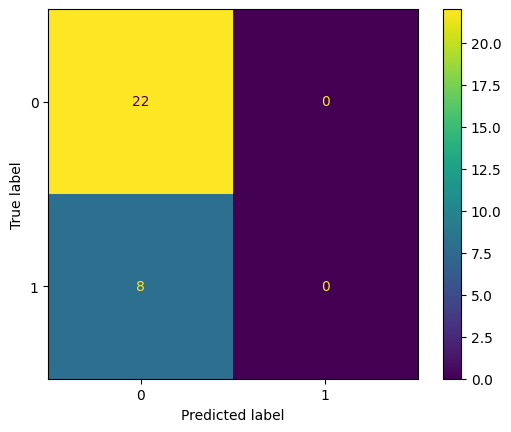

In [ ]:
#Calculating accuracy and confuison matrix values
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 

# accuracy=[]
# confusion_matrix_list=[]
# proba_threshold=np.arange(0.05,0.8,0.05)
# for proba in proba_threshold:
#     predict_threshold_proba = [1 if i[0] > proba else 0 for i in predict]
#     confusion_matrix_list.append(confusion_matrix(y_test,predict_threshold_proba))
#     accuracy.append(accuracy_score(y_test,predict_threshold_proba)) 

accuracy=accuracy_score(y_test,predict)
print(f"Accuracy:{accuracy}")
disp=ConfusionMatrixDisplay(confusion_matrix(y_test,predict))
disp.plot()



In [ ]:
# import  matplotlib.pyplot as plt
# plt.plot(proba_threshold,accuracy)
# plt.xlabel("Probability Threshold")
# plt.ylabel("Accuracy")
# plt.show()

In [ ]:

# disp=ConfusionMatrixDisplay(confusion_matrix_list[0])
# disp.plot()
# for i in range(0,len(confusion_matrix_list)):
#     disp=ConfusionMatrixDisplay(confusion_matrix_list[i])
#     plt.title(f"Proba Threshold {proba_threshold[i]}")
#     disp.plot()
